<a href="https://colab.research.google.com/github/jtthebot1/projects/blob/main/Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Install livelossplot dependency
!pip install livelossplot==0.3.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#Import required packages
from torchvision.models.alexnet import AlexNet
from torchvision.transforms.transforms import Resize
import torch

import torchvision
import torchvision.transforms as transforms

import torchvision.models as models
AlexNet = models.AlexNet()

#model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)


import torch.nn as nn
import torch.optim as optim
import numpy as np

from torch.utils.data import Subset

import torch.nn as nn
import torch.nn.functional as F

# Simple convolutional neural network (AlexNet)
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

# Normalization of images theough flips horizontally and random crops, and RBG pixel value
# normalization 
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Get the CIFAR training data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=256,
                                          shuffle=True,
                                          num_workers=4,
                                          drop_last=True)

test_and_val_set = torchvision.datasets.CIFAR10(root='./data',
                                       train=False,
                                       download=True,
                                       transform=transform_test)

# Splitting dataset into valset and test set.
indices = np.arange(len(test_and_val_set))
val_set = Subset(test_and_val_set, indices[:5000])
test_set = Subset(test_and_val_set, indices[5000:])

val_set_loader = torch.utils.data.DataLoader(val_set, batch_size=256, shuffle=False, num_workers=2)
test_set_loader = torch.utils.data.DataLoader(test_set, batch_size=256, shuffle=False, num_workers=2)

# Define a loss function which is cross entropy
criterion = nn.CrossEntropyLoss().cuda()


# Define our network, put it on GPU and set it up into a training mode.
net = AlexNet()
net = net.cuda()
net.train()

# Define optimizer and learning rate.
optimizer = optim.SGD(net.parameters(), lr=0.06, momentum=0.9)

# Define a validation function which will be run after each epoch to
# see if accuracy of our model improved or worsened.
def validate():
    
    net.eval()
    
    counter = 0
    correctly_predicted_counter = 0

    with torch.no_grad():

        for batch_idx, (inputs, targets) in enumerate(val_set_loader):

            inputs, targets = inputs.cuda(), targets.cuda()

            outputs = net(inputs)
            _, predicted_classes = outputs.max(1)

            counter += targets.size(0)
            correctly_predicted_counter += (predicted_classes == targets).sum().item()
    
    accuracy = float(correctly_predicted_counter) / counter
    
    predicted_classes_list = []

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_set_loader):
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = net(inputs)
            _, predicted_classes = outputs.max(1)
            predicted_classes_list += list(map(lambda x: str(x), predicted_classes.cpu().detach().numpy().tolist()))

    predicted_classes_list = list(enumerate(predicted_classes_list))
    
    net.train()
    
    return accuracy, predicted_classes_list

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Files already downloaded and verified


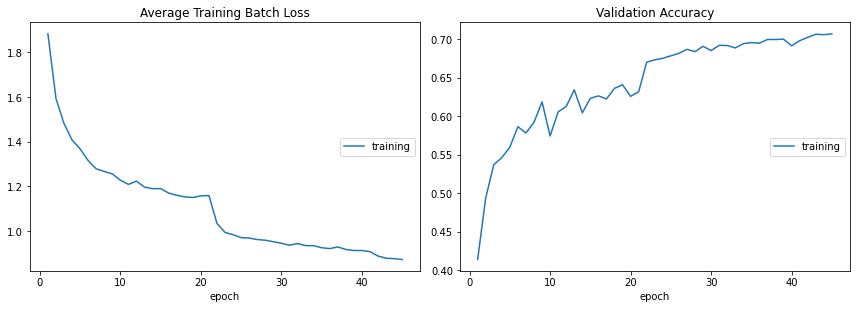

Average Training Batch Loss:
training   (min:    0.872, max:    1.883, cur:    0.872)

Validation Accuracy:
training   (min:    0.414, max:    0.707, cur:    0.707)
0.7068


KeyboardInterrupt: ignored

In [3]:
%matplotlib inline

from livelossplot import PlotLosses

liveloss = PlotLosses()

import time
import pandas as pd

best_accuracy = 0.0

start = time.time()


for epoch_number in range(100):
    
    train_loss_list = []

    for batch_idx, (inputs, targets) in enumerate(trainloader):

        inputs, targets = inputs.cuda(), targets.cuda()

        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss_list.append(loss.data.item())
    
    if epoch_number == 20:

        for param_group in optimizer.param_groups:

            param_group['lr'] = 0.01

    if epoch_number == 40:

        for param_group in optimizer.param_groups:

            param_group['lr'] = 0.001
        
        
        
    current_accuracy, predicted_classes_list = validate()

    liveloss.update({'Average Training Batch Loss': sum(train_loss_list) / len(train_loss_list),
                     'Validation Accuracy': current_accuracy})
    liveloss.draw()

    if current_accuracy > best_accuracy:

        print(current_accuracy)
        best_accuracy = current_accuracy
        torch.save(net.state_dict(), 'resnet_20_cifar10_kaggle.pth')
        
        # Saving best predictions so far
        submission_df = pd.DataFrame(predicted_classes_list, columns = ['Id', 'Category'])
        submission_df = submission_df['Category']
        submission_df = submission_df.replace(0)
        submission_df = pd.DataFrame(submission_df)
        submission_df['Id'] = submission_df.index
        submission_df = submission_df[['Id', 'Category']]
        submission_df.to_csv('cifar_10_best_submission.csv', index=False)
        
end = time.time()
print(end - start)

# PLot below